<a href="https://colab.research.google.com/github/arjo31/PCOS-Image-Classification/blob/main/Pcos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import shutil
from keras import layers
from keras import losses
from keras.regularizers import L2
from keras import metrics
import tensorflow_probability as tfp

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.chdir("/content/drive/My Drive/PCOSGen-train")


In [4]:
output_folder = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
healthy = os.path.join(output_folder, "Healthy")
unhealthy = os.path.join(output_folder, "Unhealthy")

os.makedirs(healthy, exist_ok = True)
os.makedirs(unhealthy, exist_ok = True)

In [5]:
dataset_path = r"/content/drive/My Drive/PCOSGen-train/class_label.xlsx"
df = pd.read_excel(dataset_path)
df.head()

,imagePath,Healthy
0,100image13.jpg,1
1,100image2.jpg,1
2,100image65.jpg,0
3,100image71.jpg,0
4,100image83.jpg,0


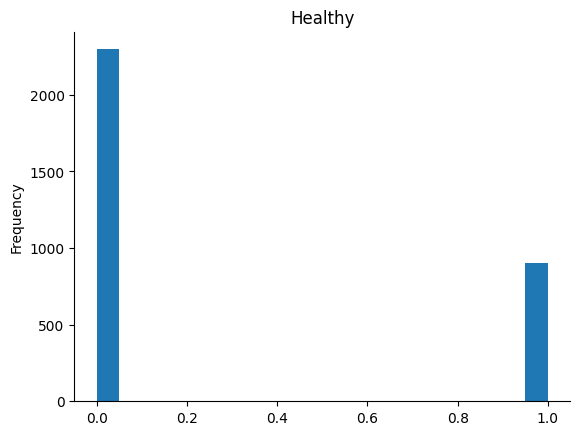

In [6]:
df['Healthy'].plot(kind='hist', bins=20, title='Healthy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
for index, row in df.iterrows():
  imgPath = row['imagePath']
  label = row['Healthy']

  source_path = os.path.join(r"/content/drive/My Drive/PCOSGen-train/images",imgPath)

  if (label==1):
    dest_path = os.path.join(healthy, imgPath)
  elif (label==0):
    dest_path = os.path.join(unhealthy, imgPath)

  shutil.copyfile(source_path, dest_path)

In [8]:
directory_path = r"/content/drive/My Drive/PCOSGen-train/Image Dataset"
CLASS_NAMES = ["Healthy", "Unhealthy"]

In [43]:
training_dataset, valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256,256),
    class_names = CLASS_NAMES,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'both'
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.


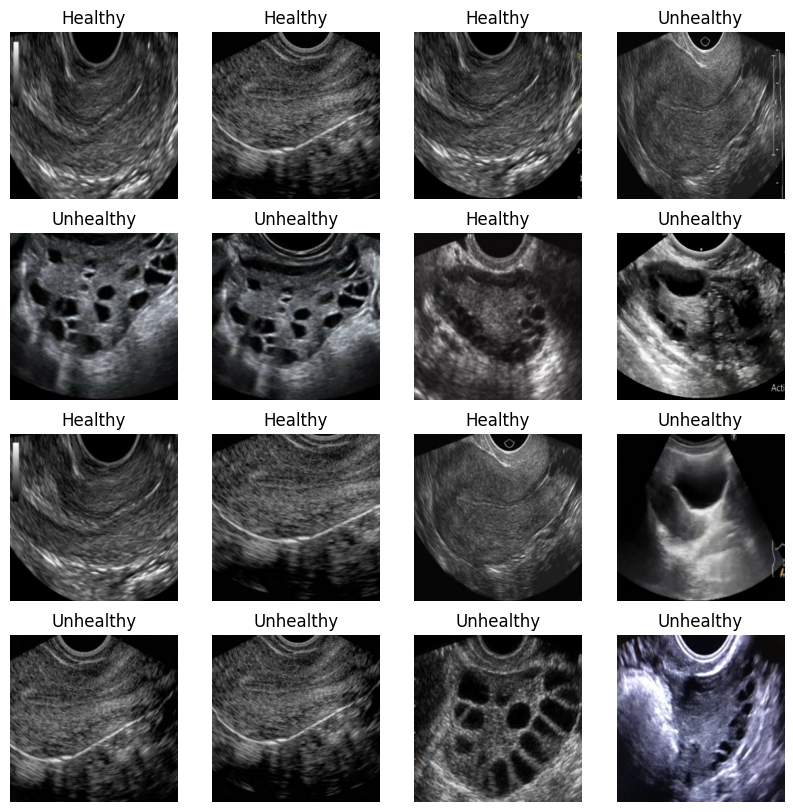

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i].numpy().astype('uint8')[0]])
    plt.axis("off")
plt.show()

In [11]:
resize_rescale_layers = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [12]:
augment_layers = tf.keras.Sequential([
    layers.RandomRotation(factor = (-0.025,0.025),),
    layers.RandomFlip(mode = 'horizontal',),
    layers.RandomContrast(factor = 0.1),
])

def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [45]:
training_dataset = (training_dataset.map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
valid_dataset = (valid_dataset.prefetch(tf.data.AUTOTUNE))

In [14]:
CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS" : 100,
    "DROPOUT_RATE" : 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 1024,
    "N_DENSE_2" : 128,
    "NUM_CLASSES" : 2
}

In [15]:
lenet_model = tf.keras.Sequential([
    layers.InputLayer(input_shape = (None,None,3)),
    resize_rescale_layers,

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS'], kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),
    layers.Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

    layers.Conv2D(filters = CONFIGURATION['N_FILTERS']*2 + 4, kernel_size = CONFIGURATION['KERNEL_SIZE'], strides = CONFIGURATION['N_STRIDES'], activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = CONFIGURATION['POOL_SIZE'], strides = CONFIGURATION['N_STRIDES']*2),

    layers.Flatten(),
    layers.Dense(CONFIGURATION['N_DENSE_1'], activation='relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    layers.Dense(CONFIGURATION['N_DENSE_2'],activation = 'relu', kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    layers.BatchNormalization(),

    layers.Dense(1, activation = 'sigmoid')

])

In [16]:
lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [17]:
lenet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
history = lenet_model.fit(training_dataset, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 34s 299ms/step - loss: 0.6470 - accuracy: 0.6707 - val_loss: 1.5192 - val_accuracy: 0.2703
Epoch 2/50
80/80 [==============================] - 24s 285ms/step - loss: 0.4828 - accuracy: 0.7437 - val_loss: 1.5270 - val_accuracy: 0.3469
Epoch 3/50
80/80 [==============================] - 25s 299ms/step - loss: 0.4832 - accuracy: 0.7504 - val_loss: 1.0919 - val_accuracy: 0.3922
Epoch 4/50
80/80 [==============================] - 26s 318ms/step - loss: 0.4582 - accuracy: 0.7563 - val_loss: 1.1208 - val_accuracy: 0.4094
Epoch 5/50
80/80 [==============================] - 25s 295ms/step - loss: 0.4510 - accuracy: 0.7594 - val_loss: 0.9747 - val_accuracy: 0.4328
Epoch 6/50
80/80 [==============================] - 25s 295ms/step - loss: 0.4486 - accuracy: 0.7691 - val_loss: 0.7264 - val_accuracy: 0.5453
Epoch 7/50
80/80 [==============================] - 25s 305ms/step - loss: 0.4400 - accuracy: 0.7711 - val_loss: 0.7559 - val_accuracy: 0.5172

In [19]:
lenet_model.evaluate(valid_dataset)

20/20 [==============================] - 3s 155ms/step - loss: 0.6927 - accuracy: 0.7484


[0.6926895380020142, 0.7484375238418579]

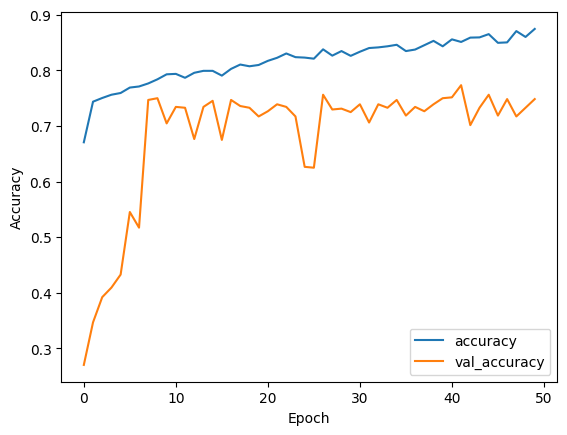

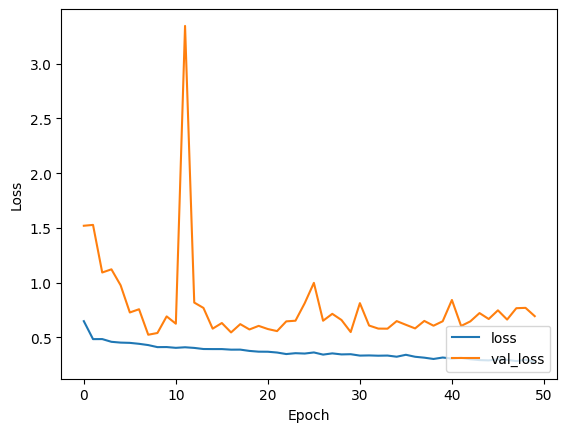

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


CutMix Data Augmentation

In [21]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, 256).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(256*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, 256)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, 256)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, 256)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, 256)

  r_w = x_b_r - r_x
  if (r_w==0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h==0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [22]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, 256, 256)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, 256, 256)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(256**2), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image,label

In [23]:
train_dataset_1 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = training_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [24]:
training_dataset_cutmix = (mixed_dataset.map(cutmix, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

In [25]:
training_dataset_cutmix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [26]:
valid_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [27]:
history_cutmix = lenet_model.fit(training_dataset_cutmix, epochs = 50, validation_data = valid_dataset, verbose = 1)

Epoch 1/50
80/80 [==============================] - 74s 874ms/step - loss: 0.4603 - accuracy: 0.5207 - val_loss: 0.5817 - val_accuracy: 0.7156
Epoch 2/50
80/80 [==============================] - 76s 904ms/step - loss: 0.4344 - accuracy: 0.5219 - val_loss: 0.6151 - val_accuracy: 0.7437
Epoch 3/50
80/80 [==============================] - 74s 875ms/step - loss: 0.4216 - accuracy: 0.5391 - val_loss: 0.5543 - val_accuracy: 0.7359
Epoch 4/50
80/80 [==============================] - 76s 887ms/step - loss: 0.4480 - accuracy: 0.5289 - val_loss: 1.1059 - val_accuracy: 0.4437
Epoch 5/50
80/80 [==============================] - 74s 884ms/step - loss: 0.4292 - accuracy: 0.5277 - val_loss: 0.6111 - val_accuracy: 0.7469
Epoch 6/50
80/80 [==============================] - 78s 908ms/step - loss: 0.4064 - accuracy: 0.5230 - val_loss: 0.5886 - val_accuracy: 0.7203
Epoch 7/50
80/80 [==============================] - 85s 1s/step - loss: 0.4404 - accuracy: 0.5277 - val_loss: 0.5754 - val_accuracy: 0.7391
Ep

In [28]:
lenet_model.evaluate(valid_dataset)

20/20 [==============================] - 2s 94ms/step - loss: 0.7572 - accuracy: 0.7172


[0.7572309970855713, 0.7171875238418579]

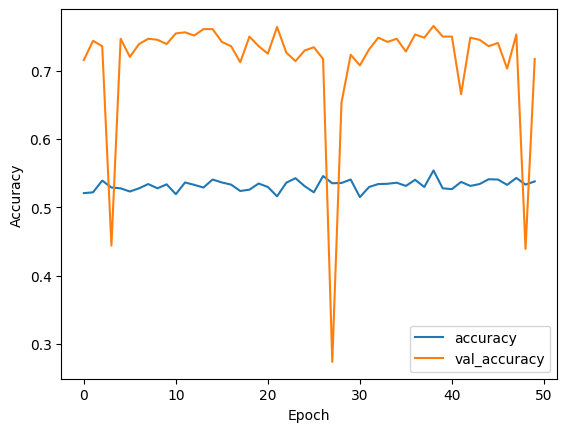

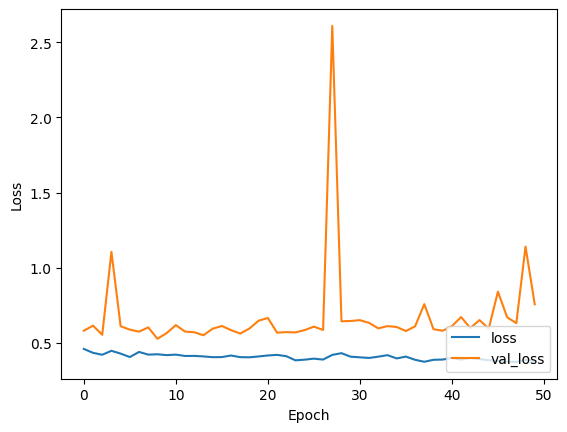

In [29]:
plt.plot(history_cutmix.history['accuracy'], label='accuracy')
plt.plot(history_cutmix.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history_cutmix.history['loss'], label='loss')
plt.plot(history_cutmix.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()


In [50]:
for images, labels in valid_dataset.take(1):
  for i in range(32):
    print(lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0])

1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 17ms/step


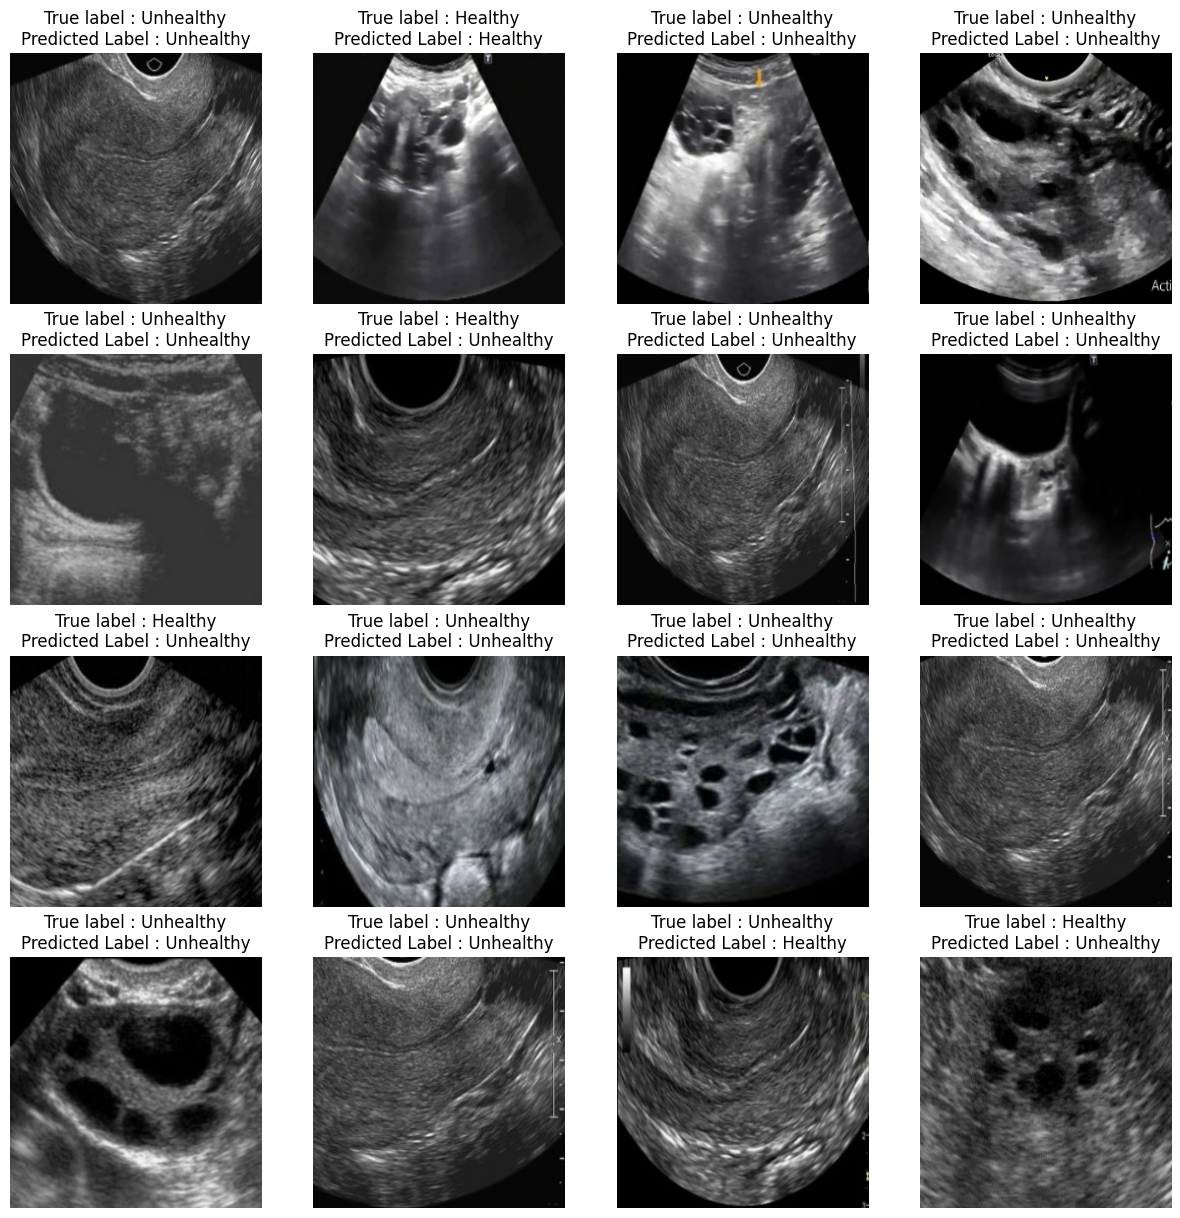

In [52]:
plt.figure(figsize=(15, 15))

for images, labels in valid_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    predicted_label = lenet_model.predict(tf.expand_dims(images[i], axis = 0))[0][0]
    if (predicted_label >= 0.5):
      predicted_label = 1
    else:
      predicted_label = 0
    plt.title("True label : " + CLASS_NAMES[labels[i].numpy().astype('uint8')[0]] + "\n" + "Predicted Label : " + CLASS_NAMES[predicted_label])

    plt.axis('off')
